# Description

In 2019, an estimated 5 million people were diagnosed with a cancer of the gastro-intestinal tract worldwide. Of these patients, about half are eligible for radiation therapy, usually delivered over 10-15 minutes a day for 1-6 weeks. Radiation oncologists try to deliver high doses of radiation using X-ray beams pointed to tumors while avoiding the stomach and intestines. With newer technology such as integrated magnetic resonance imaging and linear accelerator systems, also known as MR-Linacs, oncologists are able to visualize the daily position of the tumor and intestines, which can vary day to day. In these scans, radiation oncologists must manually outline the position of the stomach and intestines in order to adjust the direction of the x-ray beams to increase the dose delivery to the tumor and avoid the stomach and intestines. This is a time-consuming and labor intensive process that can prolong treatments from 15 minutes a day to an hour a day, which can be difficult for patients to tolerate—unless deep learning could help automate the segmentation process. A method to segment the stomach and intestines would make treatments much faster and would allow more patients to get more effective treatment.

The UW-Madison Carbone Cancer Center is a pioneer in MR-Linac based radiotherapy, and has treated patients with MRI guided radiotherapy based on their daily anatomy since 2015. UW-Madison has generously agreed to support this project which provides anonymized MRIs of patients treated at the UW-Madison Carbone Cancer Center. The University of Wisconsin-Madison is a public land-grant research university in Madison, Wisconsin. The Wisconsin Idea is the university's pledge to the state, the nation, and the world that their endeavors will benefit all citizens.

In this competition, you’ll create a model to automatically segment the stomach and intestines on MRI scans. The MRI scans are from actual cancer patients who had 1-5 MRI scans on separate days during their radiation treatment. You'll base your algorithm on a dataset of these scans to come up with creative deep learning solutions that will help cancer patients get better care.
![nn](../data/description.jpg)
*In this figure, the tumor (pink thick line) is close to the stomach (red thick line). High doses of radiation are directed to the tumor while avoiding the stomach. The dose levels are represented by the rainbow of outlines, with higher doses represented by red and lower doses represented by green. *

Cancer takes enough of a toll. If successful, you'll enable radiation oncologists to safely deliver higher doses of radiation to tumors while avoiding the stomach and intestines. This will make cancer patients' daily treatments faster and allow them to get more effective treatment with less side effects and better long-term cancer control.

Acknowledgments:
Sangjune Laurence Lee MSE MD FRCPC DABR
Poonam Yadav Ph.D., DABR
Yin Li PhD
Jason J. Meudt BS, RTT
Jessica Strang
Dustin Hebel
Alyx Alfson MS CMD, R.T.(T)
Stephanie J. Olson RTT (BS), CMD (MS)
Tera R. Kruser MS, RTT, CMD
Jennifer B Smilowitz, Ph.D., DABR, FAAPM
Kailee Borchert
Brianne Loritz
John Bayouth PhD
Michael Bassetti MD PhD

Work funded by the University of Wisconsin Carbone Cancer Center Pancreas Pilot Research Grant.

# Evaluation

This competition is evaluated on the mean Dice coefficient and 3D Hausdorff distance. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:
\begin{align*}
    \frac{2 * |A \cap B|}{|A| + |B|}
\end{align*}

where X is the predicted set of pixels and Y is the ground truth. The Dice coefficient is defined to be 0 when both X and Y are empty. The leaderboard score is the mean of the Dice coefficients for each image in the test set.

Hausdorff distance is a method for calculating the distance between segmentation objects A and B, by calculating the furthest point on object A from the nearest point on object B. For 3D Hausdorff, we construct 3D volumes by combining each 2D segmentation with slice depth as the Z coordinate and then find the Hausdorff distance between them. (In this competition, the slice depth for all scans is set to 1.) The scipy code for Hausdorff is linked. The expected / predicted pixel locations are normalized by image size to create a bounded 0-1 score.

The two metrics are combined, with a weight of 0.4 for the Dice metric and 0.6 for the Hausdorff distance.

Submission File
In order to reduce the submission file size, our metric uses run-length encoding on the pixel values.  Instead of submitting an exhaustive list of indices for your segmentation, you will submit pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).

Note that, at the time of encoding, the mask should be binary, meaning the masks for all objects in an image are joined into a single large mask. A value of 0 should indicate pixels that are not masked, and a value of 1 will indicate pixels that are masked.

The competition format requires a space delimited list of pairs. For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask. The metric checks that the pairs are sorted, positive, and the decoded pixel values are not duplicated. The pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

The file should contain a header and have the following format:

id,class,predicted  
1,large_bowel,1 1 5 1  
1,small_bowel,1 1  
1,stomach,1 1  
2,large_bowel,1 5 2 17  
etc.  

# Import

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load train.csv

In [10]:
train_data = pd.read_csv("../data/train.csv")
train_data

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN
115484,case30_day0_slice_0143,stomach,NaN
115485,case30_day0_slice_0144,large_bowel,NaN
115486,case30_day0_slice_0144,small_bowel,NaN


# Null check

In [15]:
train_data.isnull().sum()

id                  0
class               0
segmentation    81575
dtype: int64

# Check non-null data

In [16]:
train_data[~train_data["segmentation"].isna()]

,id,class,segmentation
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...
...,...,...,...
115459,case30_day0_slice_0135,small_bowel,22540 1 22804 5 23069 7 23334 10 23600 11 2386...
115461,case30_day0_slice_0136,large_bowel,18746 7 19009 23 19038 7 19273 44 19537 49 198...
115462,case30_day0_slice_0136,small_bowel,23079 1 23343 6 23608 9 23874 11 24139 13 2440...
115464,case30_day0_slice_0137,large_bowel,18746 2 19010 8 19040 3 19274 25 19302 12 1953...


# Make DF

## Define image path

In [31]:
#check number of images
import glob, os
train_dir = "../data/train/"
train_images = glob.glob(os.path.join(train_dir, "**", "*.png"), recursive=True)
len(train_images)

38496

## Make feature from file name

In [64]:
reg_extract = re.compile(r"case(?P<case>\d{1,3})_day(?P<day>\d{1,}).*slice_(?P<slice>\d{1,})_(?P<height>\d{1,})_(?P<width>\d{1,})_(?P<height_pixel>\d{1,}.\d{1,})_(?P<width_pixel>\d{1,}.\d{1,})")
df_data = []
for train_image in train_images:
    df_dict = {}
    df_dict["case"] = reg_extract.search(train_image).group("case")
    df_dict["day"] = reg_extract.search(train_image).group("day")
    df_dict["slice"] = reg_extract.search(train_image).group("slice")
    df_dict["height"] = reg_extract.search(train_image).group("height")
    df_dict["width"] = reg_extract.search(train_image).group("width")
    df_dict["height_pixel"] = reg_extract.search(train_image).group("height_pixel")
    df_dict["width_pixel"] = reg_extract.search(train_image).group("width_pixel")
    df_dict["id"] = "case" + df_dict["case"] + "_day" + df_dict["day"] + "_slice_" + df_dict["slice"]
    df_data.append(df_dict)

## Merge with train data

In [70]:
df = train_data.merge(pd.DataFrame(df_data), on="id", how="left")
df

,id,class,segmentation,case,day,slice,height,width,height_pixel,width_pixel
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,266,266,1.50,1.50
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,266,266,1.50,1.50
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,266,266,1.50,1.50
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,266,266,1.50,1.50
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,266,266,1.50,1.50
...,...,...,...,...,...,...,...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN,30,0,0143,266,266,1.50,1.50
115484,case30_day0_slice_0143,stomach,NaN,30,0,0143,266,266,1.50,1.50
115485,case30_day0_slice_0144,large_bowel,NaN,30,0,0144,266,266,1.50,1.50
115486,case30_day0_slice_0144,small_bowel,NaN,30,0,0144,266,266,1.50,1.50


## Reshape dataframe

In [108]:
index_large_bowel = list(range(0, df.shape[0], 3))
index_small_bowel = list(range(1, df.shape[0], 3))
index_stomach = list(range(2, df.shape[0], 3))

large_bowel_df = df.loc[index_large_bowel].reset_index(drop=True).drop("class", axis=1).rename(columns={"segmentation":"large_bowel"})
small_bowel_df = df.loc[index_small_bowel].reset_index(drop=True).drop("class", axis=1).rename(columns={"segmentation":"small_bowel"})
stomach_df = df.loc[index_stomach].reset_index(drop=True).drop("class", axis=1).rename(columns={"segmentation":"stomach"})
merge_df = large_bowel_df.merge(small_bowel_df[["id", "small_bowel"]], on="id", how="left")
merge_df = merge_df.merge(stomach_df[["id", "stomach"]], on="id", how="left")
merge_df = merge_df.reindex(columns=[
    "id",
    "large_bowel",
    "small_bowel",
    "stomach",
    "case",
    "day",
    "slice",
    "height",
    "width",
    "height_pixel",
    "width_pixel"
])
merge_df

,id,large_bowel,small_bowel,stomach,case,day,slice,height,width,height_pixel,width_pixel
0,case123_day20_slice_0001,NaN,NaN,NaN,123,20,0001,266,266,1.50,1.50
1,case123_day20_slice_0002,NaN,NaN,NaN,123,20,0002,266,266,1.50,1.50
2,case123_day20_slice_0003,NaN,NaN,NaN,123,20,0003,266,266,1.50,1.50
3,case123_day20_slice_0004,NaN,NaN,NaN,123,20,0004,266,266,1.50,1.50
4,case123_day20_slice_0005,NaN,NaN,NaN,123,20,0005,266,266,1.50,1.50
...,...,...,...,...,...,...,...,...,...,...,...
38491,case30_day0_slice_0140,NaN,NaN,NaN,30,0,0140,266,266,1.50,1.50
38492,case30_day0_slice_0141,NaN,NaN,NaN,30,0,0141,266,266,1.50,1.50
38493,case30_day0_slice_0142,NaN,NaN,NaN,30,0,0142,266,266,1.50,1.50
38494,case30_day0_slice_0143,NaN,NaN,NaN,30,0,0143,266,266,1.50,1.50


# Save DataFrame

In [109]:
merge_df.to_pickle("../data/train_df.pkl")

# Plot value counts

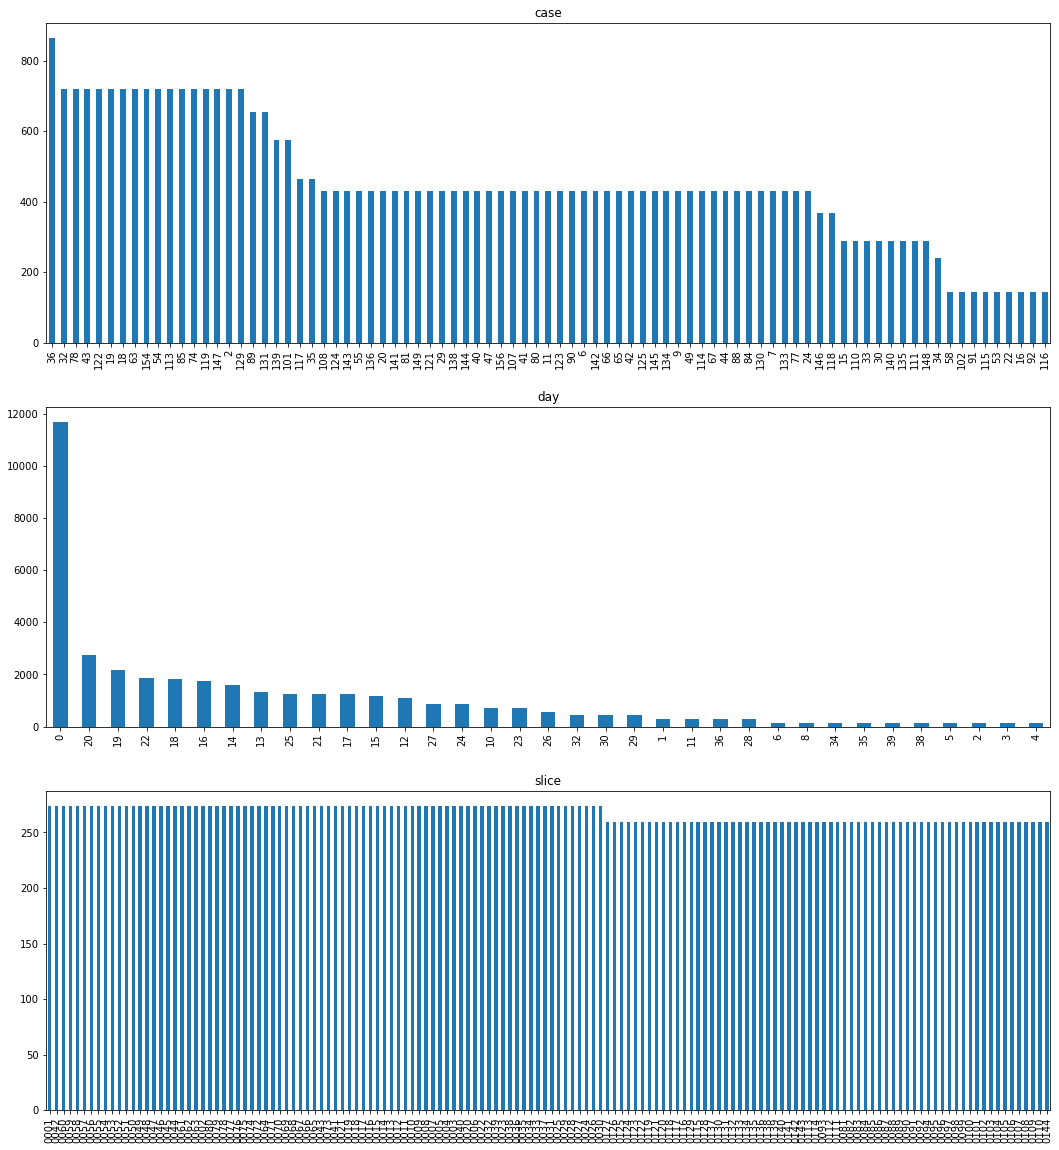

In [119]:
fig = plt.figure(figsize=(18, 20))
for index, col in enumerate(["case", "day", "slice"]):
    ax = fig.add_subplot(3, 1, index + 1)
    ax.set_title(col)
    merge_df[col].value_counts().plot(kind="bar", ax=ax)

In [143]:
import cv2
for i in train_images:
    img = cv2.imread(i)
    if img.sum()>500:
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imshow(rgb)
        break
    

TypeError: imshow() missing required argument 'mat' (pos 2)

In [141]:
rgb

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)